In [5]:

import os
import concurrent.futures
import nibabel as nib
from nibabel import load as load_nifti_image
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import rotate
from skimage.util import montage
import shutil
from nilearn import image as nlimage
from nilearn import plotting as nlplt
from nilearn.plotting import find_xyz_cut_coords
import imageio.v2 as imageio
import kagglehub


/media/panos/B/THESIS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Load the Images and Masks

In [14]:
def load_nifti_image(file_path):
    """Load a NIfTI image and return a NumPy array."""
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

# Define paths
data_dir = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
print(data_dir)




/home/panos/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1


In [15]:
data_dir = data_dir + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
print(data_dir)
patient_dirs = os.listdir(data_dir)
print(patient_dirs)

/home/panos/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
['BraTS20_Training_025', 'BraTS20_Training_203', 'BraTS20_Training_008', 'BraTS20_Training_251', 'BraTS20_Training_321', 'BraTS20_Training_022', 'BraTS20_Training_152', 'BraTS20_Training_230', 'BraTS20_Training_147', 'BraTS20_Training_121', 'BraTS20_Training_094', 'BraTS20_Training_075', 'BraTS20_Training_217', 'BraTS20_Training_081', 'BraTS20_Training_172', 'BraTS20_Training_114', 'BraTS20_Training_353', 'BraTS20_Training_220', 'BraTS20_Training_359', 'BraTS20_Training_211', 'BraTS20_Training_013', 'BraTS20_Training_077', 'BraTS20_Training_345', 'BraTS20_Training_113', 'BraTS20_Training_231', 'BraTS20_Training_193', 'BraTS20_Training_058', 'BraTS20_Training_158', 'BraTS20_Training_362', 'BraTS20_Training_069', 'BraTS20_Training_146', 'BraTS20_Training_232', 'BraTS20_Training_309', 'BraTS20_Training_347', 'BraTS20_Training_014', 'BraTS20_Trai

In [16]:
# Example: Load data for one patient
patient_id = 'BraTS20_Training_001'
patient_path = os.path.join(data_dir, patient_id)

# Modality file names
modalities = ['flair', 't1', 't1ce', 't2']

images = {}
for modality in modalities:
    modality_filename = f'{patient_id}_{modality}.nii'
    modality_path = os.path.join(patient_path, modality_filename)
    images[modality] = load_nifti_image(modality_path)

# Load the segmentation mask
mask_filename = f'{patient_id}_seg.nii'
mask_path = os.path.join(patient_path, mask_filename)
mask = load_nifti_image(mask_path)

2. Check for Missing/Corrupted Data

In [20]:
import os
import concurrent.futures
from nibabel import load as load_nifti_image
import logging

# Set up logging
logging.basicConfig(filename='missing_files.log', level=logging.INFO)

def check_file(modality_path):
    if not os.path.exists(modality_path):
        return modality_path, 'missing'
    else:
        try:
            load_nifti_image(modality_path)
            return modality_path, 'ok'
        except Exception as e:
            return modality_path, f'corrupted: {str(e)}'

def check_data_integrity(data_dir, modalities, has_seg=True):
    missing_files = []
    corrupted_files = []
    patient_ids = [d for d in os.listdir(data_dir) if d.startswith('BraTS20_Training_')]
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for patient_id in patient_ids:
            patient_path = os.path.join(data_dir, patient_id)
            for modality in modalities:
                modality_filename = f'{patient_id}_{modality}.nii'
                modality_path = os.path.join(patient_path, modality_filename)
                futures.append(executor.submit(check_file, modality_path))
            if has_seg:
                seg_filename = f'{patient_id}_seg.nii'
                seg_path = os.path.join(patient_path, seg_filename)
                futures.append(executor.submit(check_file, seg_path))
        
        for future in concurrent.futures.as_completed(futures):
            modality_path, status = future.result()
            if status == 'missing':
                missing_files.append(modality_path)
                logging.info(f'Missing file: {modality_path}')
            elif status.startswith('corrupted'):
                corrupted_files.append((modality_path, status.split(': ', 1)[1]))
    
    return missing_files, corrupted_files

# Usage
data_dir = '/home/panos/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
modalities = ['flair', 't1', 't1ce', 't2']
missing_files, corrupted_files = check_data_integrity(data_dir, modalities, has_seg=True)

if missing_files:
    print("Missing files found:")
    for file in missing_files:
        print(file)
else:
    print("No missing files.")

if corrupted_files:
    print("\nCorrupted files found:")
    for file, error in corrupted_files:
        print(f"{file}: {error}")
else:
    print("No corrupted files.")

No missing files.
No corrupted files.


3. Define Functions to Load and Display Images

Patient ID: BraTS20_Training_059


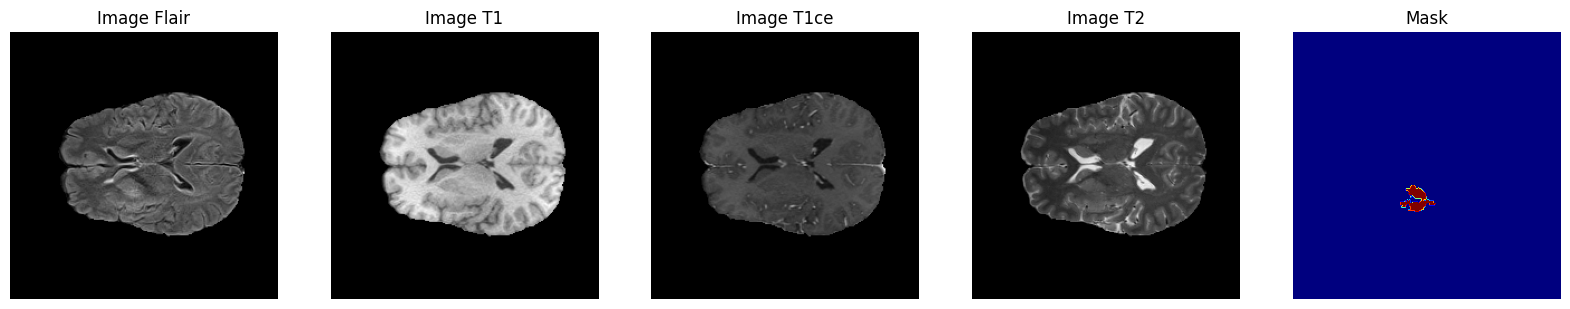

Patient ID: BraTS20_Training_086


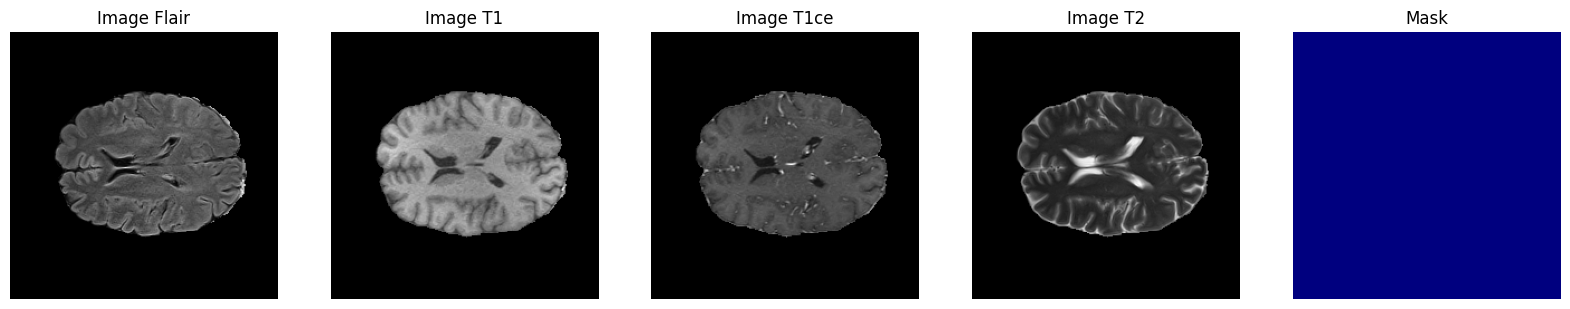

Patient ID: BraTS20_Training_053


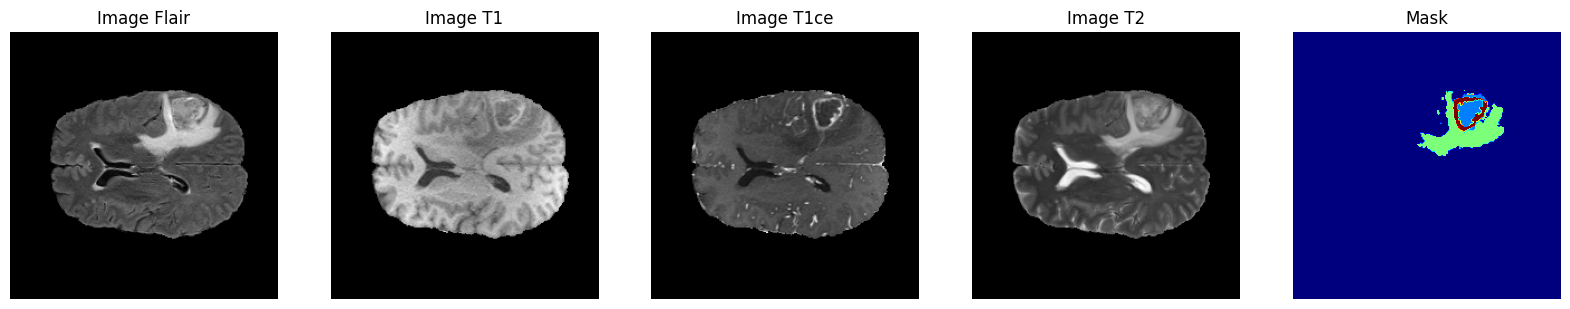

Patient ID: BraTS20_Training_080


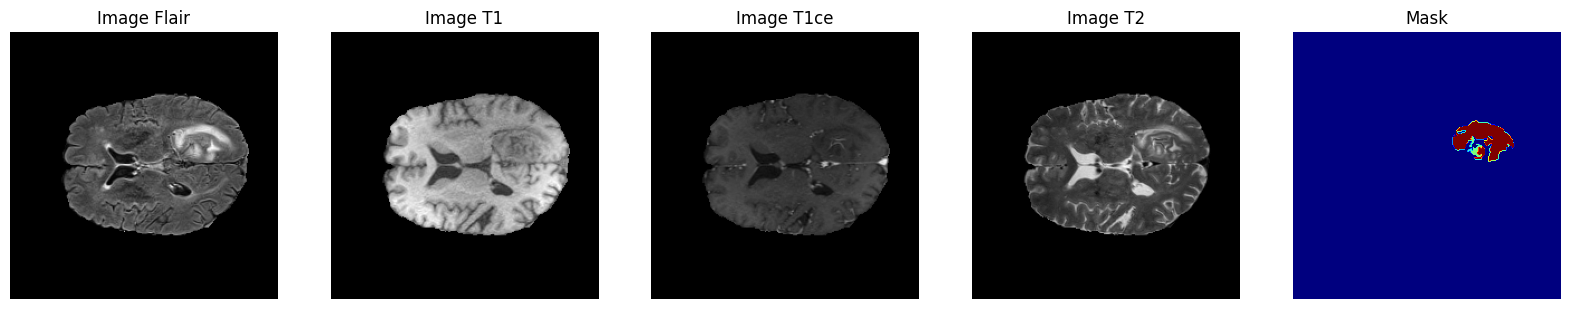

Patient ID: BraTS20_Training_096


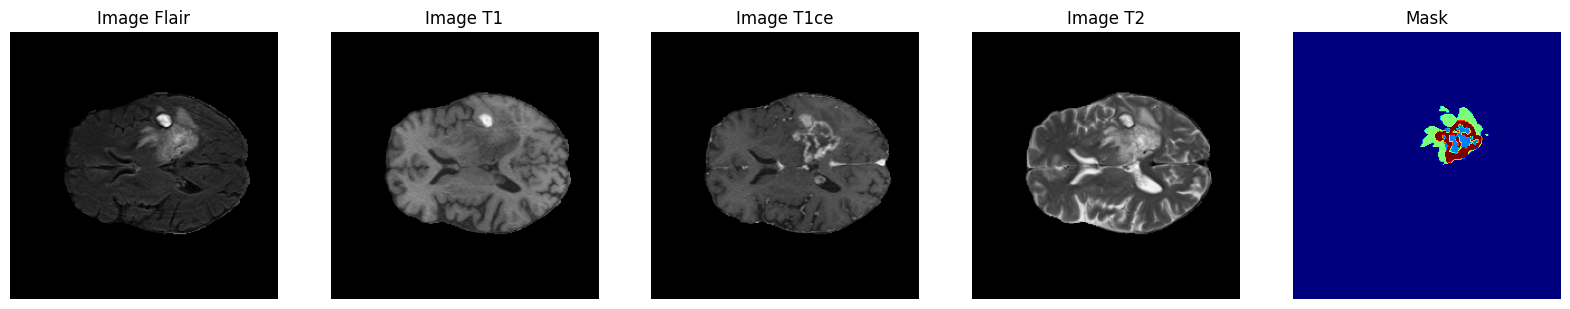

Patient ID: BraTS20_Training_033


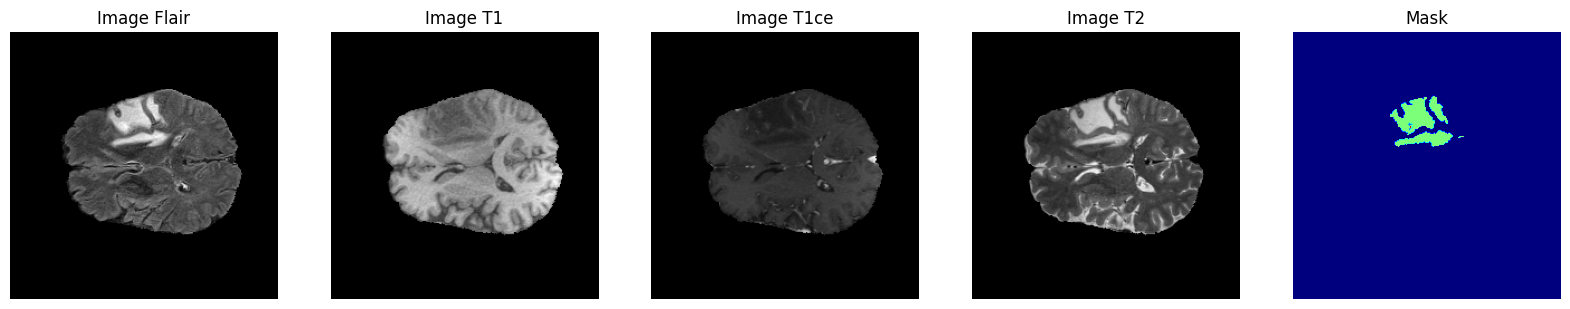

In [22]:
def load_nifti_image(file_path):
    return nib.load(file_path).get_fdata()

# Path to the training data directory
TRAIN_DATASET_PATH = '/home/panos/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

# List all patient directories
patient_ids = os.listdir(TRAIN_DATASET_PATH)

# Ensure there are enough patients to sample
num_patients_to_sample = min(6, len(patient_ids))

# Randomly select patients to visualize
example_patient_ids = random.sample(patient_ids, num_patients_to_sample)

modalities = ['flair', 't1', 't1ce', 't2']

for patient_id in example_patient_ids:
    print(f'Patient ID: {patient_id}')
    patient_path = os.path.join(TRAIN_DATASET_PATH, patient_id)
    
    images = {}
    # Load each modality
    for modality in modalities:
        modality_filename = f'{patient_id}_{modality}.nii'
        modality_path = os.path.join(patient_path, modality_filename)
        if os.path.exists(modality_path):
            images[modality] = load_nifti_image(modality_path)
        else:
            print(f"File not found: {modality_path}")
            continue
    
    # Load the segmentation mask
    mask_filename = f'{patient_id}_seg.nii'
    mask_path = os.path.join(patient_path, mask_filename)
    if os.path.exists(mask_path):
        mask = load_nifti_image(mask_path)
    else:
        print(f"Segmentation mask not found for {patient_id}")
        mask = None
    
    # Visualize the images for the patient
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))
    slice_index = images['flair'].shape[2] // 2  # Default to the middle slice
    
    axes[0].imshow(images['flair'][:, :, slice_index], cmap='gray')
    axes[0].set_title('Image Flair')
    axes[0].axis('off')
    
    axes[1].imshow(images['t1'][:, :, slice_index], cmap='gray')
    axes[1].set_title('Image T1')
    axes[1].axis('off')
    
    axes[2].imshow(images['t1ce'][:, :, slice_index], cmap='gray')
    axes[2].set_title('Image T1ce')
    axes[2].axis('off')
    
    axes[3].imshow(images['t2'][:, :, slice_index], cmap='gray')
    axes[3].set_title('Image T2')
    axes[3].axis('off')
    
    if mask is not None:
        axes[4].imshow(mask[:, :, slice_index], cmap='jet')
        axes[4].set_title('Mask')
    else:
        axes[4].set_title('No Mask')
    axes[4].axis('off')
    
    plt.show()

In [25]:
import nifti2gif.core as nifti2gif
print(dir(nifti2gif))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_mosaic_RGB', 'create_mosaic_depth', 'create_mosaic_normal', 'get_cmap', 'load_and_prepare_image', 'mimwrite', 'nb', 'np', 'os', 'parse_filename', 'resize', 'write_gif_depth', 'write_gif_normal', 'write_gif_pseudocolor', 'write_gif_rgb']


4. Gif representation of slices in 3D volume

In [27]:
import os
import shutil
import nibabel as nib
import imageio.v2 as imageio
import matplotlib.pyplot as plt

def nifti_to_gif(nifti_path, gif_path):
    # Load the NIfTI file
    img = nib.load(nifti_path)
    img_data = img.get_fdata()
    
    # Create a list to store the images
    images = []
    
    # Iterate through the slices and save each as an image
    for i in range(img_data.shape[2]):
        fig, ax = plt.subplots()
        ax.imshow(img_data[:, :, i], cmap='gray')
        ax.axis('off')
        
        # Save the image to a temporary file
        temp_img_path = f'temp_slice_{i}.png'
        plt.savefig(temp_img_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        
        # Read the image and append to the list
        images.append(imageio.imread(temp_img_path))
        
        # Remove the temporary file
        os.remove(temp_img_path)
    
    # Save the images as a GIF
    imageio.mimsave(gif_path, images, duration=0.1)

# Path to the training data directory
TRAIN_DATASET_PATH = '/home/panos/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

# Example patient ID
patient_id = 'BraTS20_Training_001'

# Copy the NIfTI file
src_path = os.path.join(TRAIN_DATASET_PATH, f'{patient_id}/{patient_id}_flair.nii')
dst_path = f'./test_gif_{patient_id}_flair.nii'
shutil.copy2(src_path, dst_path)

# Convert the copied NIfTI file to a GIF
nifti_to_gif(dst_path, f'./test_gif_{patient_id}_flair.gif')

In [28]:
%pip install --upgrade nilearn


Note: you may need to restart the kernel to use updated packages.


In [29]:
import nilearn
print(f"Nilearn version: {nilearn.__version__}")


Nilearn version: 0.10.4


/media/panos/B/THESIS/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2881: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


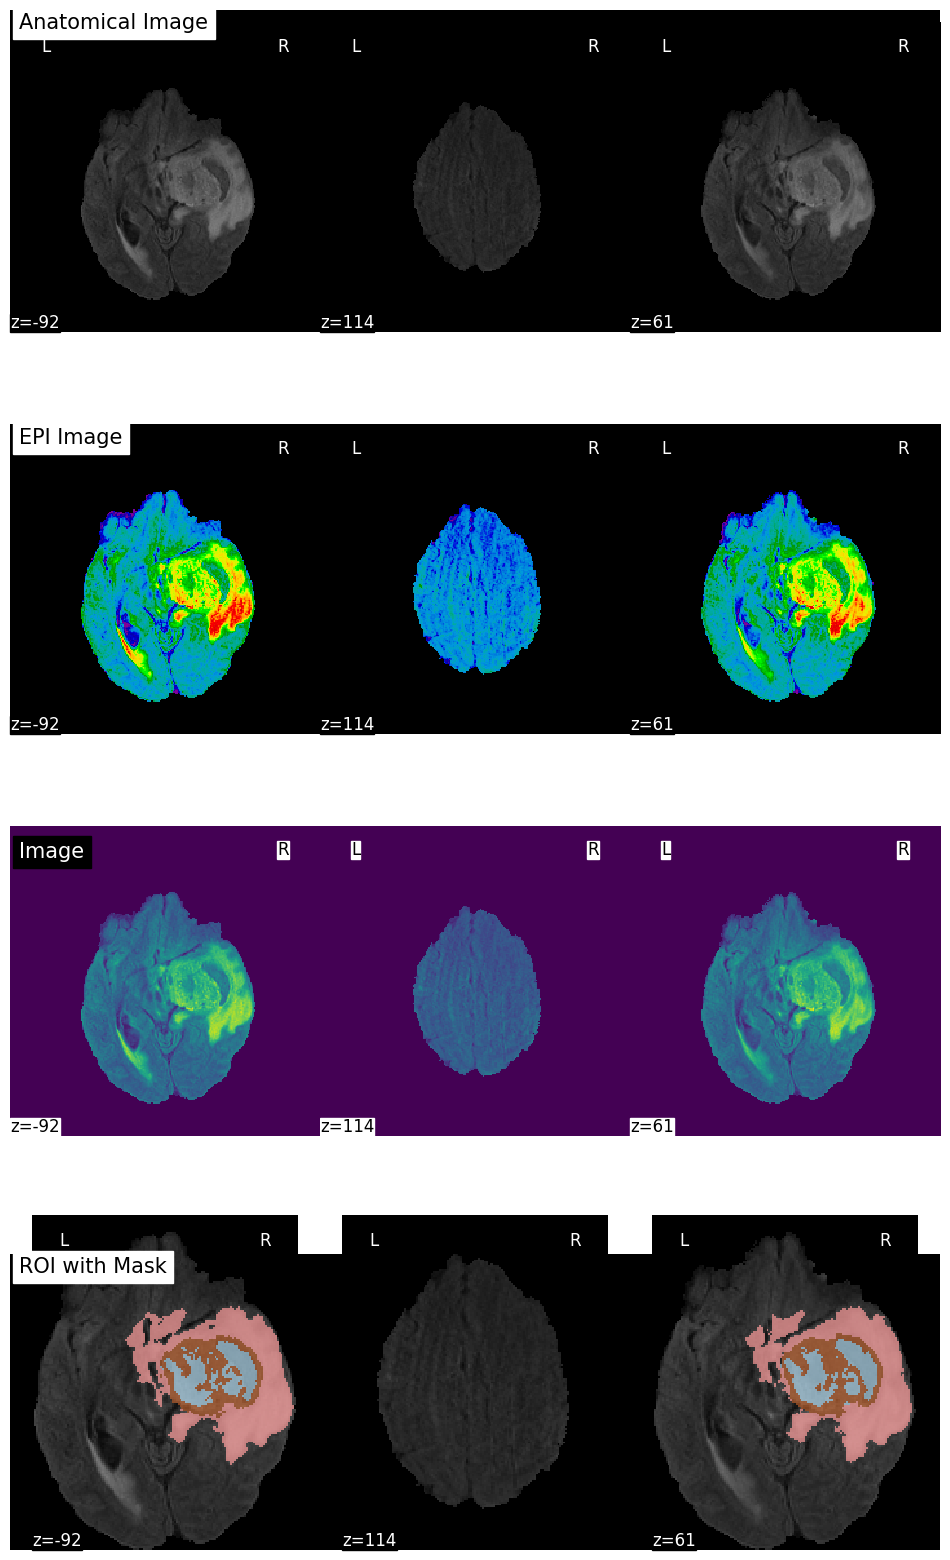

In [30]:
# Path to the training data directory
TRAIN_DATASET_PATH = r'/home/panos/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

# Example patient ID
patient_id = 'BraTS20_Training_001'

# Paths to the image and mask files
flair_path = os.path.join(TRAIN_DATASET_PATH, patient_id, f'{patient_id}_flair.nii')
seg_path = os.path.join(TRAIN_DATASET_PATH, patient_id, f'{patient_id}_seg.nii')

# Load the NIfTI image and mask
niimg = nlimage.load_img(flair_path)
nimask = nlimage.load_img(seg_path)

# Find cut coordinates centered on the tumor
cut_coords = find_xyz_cut_coords(nimask)

# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=4, figsize=(12, 20))

# Plot the anatomical image
nlplt.plot_anat(niimg, title='Anatomical Image', axes=axes[0], cut_coords=cut_coords, display_mode='z')

# Plot the EPI image
nlplt.plot_epi(niimg, title='EPI Image', axes=axes[1], cut_coords=cut_coords, display_mode='z')

# Plot the image
nlplt.plot_img(niimg, title='Image', axes=axes[2], cut_coords=cut_coords, display_mode='z')

# Plot the ROI with the mask
nlplt.plot_roi(nimask, bg_img=niimg, title='ROI with Mask', axes=axes[3], cmap='Paired', cut_coords=cut_coords, display_mode='z')

# Adjust layout and show the plot
plt.subplots_adjust(hspace=0.4)
plt.show()

START OF MODEL CODE
<<=================================================================================================================>>

In [31]:
pip install numpy scipy nibabel h5py scikit-learn tensorflow-gpu==1.15 keras==2.2.4

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.15 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.15
Note: you may need to restart the kernel to use updated packages.


git clone https://github.com/deepmedic/deepmedic.git

cd deepmedic

python setup.py install